In [1]:
# Standard library imports
import os
import sys
import warnings

# Third party imports
import numpy as np
import matplotlib.pyplot as plt
import mat73
import rpy2.robjects as robjects
from scipy.signal import butter, find_peaks, lfilter

# Local imports
from src.features.preprocessing import *
from src.visualization.data_vis import *

# Notebook magic
%matplotlib inline

In [2]:
# Load up a file of interest
recording_of_interest = "recording_1.mat"
file_data = mat73.loadmat('/'.join([os.getcwd(), 'data', 'raw', recording_of_interest]))

# Picking out some of the data structures of interest
intspike_raw = file_data['intspike'] # spike times for interneurons
pyrspike_raw = file_data['pyrspike'] # spike times for pyramidal neurons
qpspike = file_data['qpspike'] # aligned spike times 

time_pos = file_data['time_pos'] # [1, nt] time vector with the time; dt = t[1] - t[0]
pos = file_data['pos'] # position vector (x and y, [2, nt])

In [3]:
# Define some constants for the data
dt = time_pos[1] - time_pos[0]
T = dt*time_pos.size

# Separate spike times for each neuron into a 2D list 
partition_indices = partition_spikes(pyrspike_raw) # Intermediate variable
pyr_spike = separate_neuron_data(partition_indices, pyrspike_raw)

partition_indices = partition_spikes(intspike_raw)
int_spike = separate_neuron_data(partition_indices, intspike_raw)

all_spikes = []
for i in pyr_spike:
    all_spikes.append(i)
for j in int_spike:
    all_spikes.append(j)

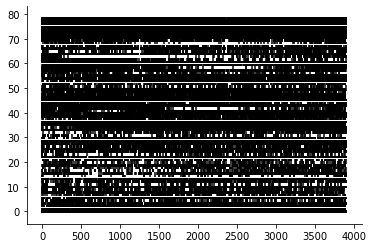

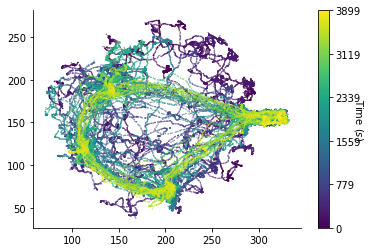

In [4]:
# Plot neuron spike times and animal motion
raster_plot(all_spikes)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    locomotion_plot(pos, T)

That raster plot is hopelessly dense in notebooks for some reason, but in a .py (with a different mpl backend??) the interneurons fire rhythmically at higher frequency than pyramidals, which fire rhythmically only at particular intervals. 

In the locomotion plot, the yellow blobs indicate reward sites and the rightmost yellow area is a rest area for the animal.

In [5]:
# Investigating the structure of maximum-liklihood aligned spikes
print(qpspike[:25, :]) # It's unclear if the first/third columns indicate neuron/trial index
print(f'aligned spikes shape: {qpspike.shape}')
print(f'aligned spikes column 1 max: {np.amax(qpspike[:, 0])}') # 14 of these
print(f'aligned spikes column 3 max: {np.amax(qpspike[:, 2])}') # 72 of these
print(f'pyramidal end label: {np.amax(pyrspike_raw[:, 0])}')
print(f'interneuron start label: {np.amin(intspike_raw[:, 0])}')
print(f'interneuron end label: {np.amax(intspike_raw[:, 0])}')

[[1.         0.01387104 1.        ]
 [1.         1.18422104 1.        ]
 [1.         1.64477104 1.        ]
 [1.         1.68432104 1.        ]
 [1.         1.82082104 1.        ]
 [1.         1.95187104 1.        ]
 [1.         2.38117104 1.        ]
 [1.         3.85962104 1.        ]
 [1.         3.86347104 1.        ]
 [1.         3.87792104 1.        ]
 [2.         0.28583305 1.        ]
 [2.         0.89618305 1.        ]
 [2.         1.76133305 1.        ]
 [2.         1.76478305 1.        ]
 [2.         1.82698305 1.        ]
 [2.         2.23173305 1.        ]
 [2.         2.26133305 1.        ]
 [2.         2.34503305 1.        ]
 [2.         2.54093305 1.        ]
 [2.         2.63228305 1.        ]
 [2.         2.65328305 1.        ]
 [2.         2.69938305 1.        ]
 [2.         3.08393305 1.        ]
 [2.         3.74873305 1.        ]
 [2.         3.75268305 1.        ]]
aligned spikes shape: (28166, 3)
aligned spikes column 1 max: 14.0
aligned spikes column 3 max: 72.

So it would seem that qpspike[:, 0] indicates trial number and qpspike[:, 2] indicates neuron index.

In [11]:
# Group together spikes for each pyramidalneuron across trials
qpspike_2 = np.fliplr(qpspike) # Put neuron labels in first column
interneuron_indices = [] # Contains row indices corresponding to interneurons
for row_i, label in enumerate(qpspike[:, 2]):
    if label in intspike_raw[:, 0]: # If the row shares a label with an interneuron
        interneuron_indices.append(row_i) # Mark it for deletion
qpspike_2 = np.delete(qpspike_2, interneuron_indices, axis=0) # Delete interneuron rows

# Side note: set() remove nonunique entries, list makes it castable as an array, which itself can be multi-indexed
pyramidal_labels = np.array(list(set(qpspike_2[:, 0]))) # Labels for remaining pyramidal neurons

# Separate spike times by neuron
neuron_partition_indices = partition_spikes(qpspike_2)
qpspike_3 = separate_neuron_data(neuron_partition_indices, qpspike_2)
print(len(qpspike_3), pyramidal_labels.shape)

# Sort spike times for each neuron across all trials
for i, spike_times in enumerate(qpspike_3):
    qpspike_3[i] = np.sort(spike_times)

# Constants for computing KDE
N = 512
bandwidth = 0.02
verbose = False

# Compute KDE
kde_x_all, kde_y_all = r_spike_kde(qpspike_3, bandwidth, N) 

dominant_frequencies = np.empty((len(kde_x_all), 2))
for i, kde_x in enumerate(kde_x_all):
    if verbose == True:
        dom_freq_fft, dom_freq_time = dominant_frequency(kde_x, kde_y_all[i], plot=True)
        print(f'Dom freq FFT: {dom_freq_fft}; Dom freq time: {dom_freq_time}')
        print(f'Dom freq error: {np.abs(dom_freq_fft - dom_freq_time)}')
    else:
        dom_freq_fft, dom_freq_time = dominant_frequency(kde_x, kde_y_all[i], plot=False)
    
    # Store the dominant frequency returned by each method
    dominant_frequencies[i, 0] = dom_freq_fft
    dominant_frequencies[i, 1] = dom_freq_time

# Clean up by ditching undefined frequencies
nan_rows = []
for row_i, val in enumerate(dominant_frequencies[:, 0]):
    if np.isnan(val) == True:
        nan_rows.append(row_i)
dominant_frequencies = np.delete(dominant_frequencies, nan_rows, axis=0) # Delete undefined frequencieTrue
print(dominant_frequencies)

58 (58,)
[[3.85469366 7.936134  ]
 [0.49414468 6.91802555]
 [7.95440535 7.4998679 ]
 [2.69334786 5.63154552]
 [3.85180817 4.81476021]
 [1.84577596 3.38392259]
 [1.72674161 1.03604496]
 [3.92277852 6.37451509]
 [7.18419278 4.78946185]
 [2.06086051 6.64055054]
 [1.38737947 1.38737947]
 [3.55122403 5.07317719]
 [3.38279694 8.45699234]
 [1.00479447 8.54075303]
 [0.62283536 1.86850608]
 [3.0098844  3.0098844 ]
 [7.59097542 7.30982818]
 [1.15123609 6.21667489]
 [0.87481873 9.18559669]
 [6.09805256 7.67902915]
 [6.82449621 3.4122481 ]
 [2.02303807 7.58639275]
 [2.09033104 4.96453622]
 [7.90726456 3.59421117]
 [3.64557042 2.31990845]
 [1.07110928 8.99731791]
 [0.97112655 8.4973573 ]
 [6.8455679  7.60618656]
 [0.55213021 7.17769273]
 [5.74227444 4.95923701]
 [2.86645058 4.16938266]
 [1.1811225  8.74030649]
 [3.0456506  7.73126692]
 [1.9200471  4.38867909]
 [2.22079653 8.8831861 ]
 [4.31410175 5.07541383]
 [1.12721582 9.01772656]
 [0.46296526 9.02782258]
 [1.51500139 9.95572345]
 [2.28382067 6.1

Seems like time domain frequency approximation is more robust than in the frequency domain. The two methods are at least not equivalent.

I'm assuming that theta frequency will be fixed (or approximately so) such that detuning is a function of dominant frequency alone. While I'll confirm this later when I get hippocampal LFP, for now let's investigate the distribution of frequencies.

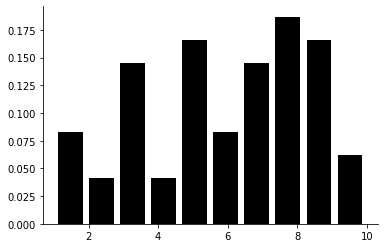

In [7]:
# Freedman-Diaconis rule for number of bins
dom_freq = dominant_frequencies[:, 1]
q3, q1 = np.percentile(dom_freq, [75, 25])
iqr = q3 - q1
h = 2*iqr*dom_freq.size**(-1/3)
num_bins = int((np.amax(dom_freq) - np.amin(dom_freq))/h)
if num_bins < 10: # Got some really low resolution histograms using it (4 bins)
    num_bins = 10

# Plot frequencies of... spike frequencies (computed in time domain)
spike_frequency_histogram(dominant_frequencies[:, 1], num_bins=num_bins)

So there is definitely a split between neurons spiking faster and slower than typical theta. If this is true, then I could just work backwards to find neuron labels that fire faster than theta during these trials, and pick out where these trials occurred in the original time series. 

So, from Wilten I need:

    - theta oscillation time series
    - to know what constitutes a trial 
    - how to determine where trials occured in original time series.

In [8]:
# Label pyramidals
theta_freq = 7 # Stand-in until I get some real data

# Initialize lists to sort neurons by theta-phase relationship
recession_i = []
locking_i = []
precession_i = []

# Sort indices based on their theta-detuning
for i, pyr_freq in enumerate(dominant_frequencies[:, 1]):
    if pyr_freq > theta_freq:
        precession_i.append(i)
    elif pyr_freq < theta_freq:
        recession_i.append(i)
    else:
        locking_i.append(i)

# Recast as an array to do list-indexing
recession_i = np.array(recession_i).astype(int)
precession_i = np.array(precession_i).astype(int)
locking_i = np.array(locking_i).astype(int)

num_neurons = dominant_frequencies[:, 1].size

# Print off the results
print(f'Number of precessing neurons: {len(precession_i)}/{num_neurons}')
print(f'Precessor labels: {pyramidal_labels[precession_i]}\n')

print(f'Number of recessing neurons: {len(recession_i)}/{num_neurons}')
print(f'Recessor labels: {pyramidal_labels[recession_i]}\n')

print(f'Number of locking neurons: {len(locking_i)}/{num_neurons}')
print(f'Locked labels: {pyramidal_labels[locking_i]}\n')

Number of precessing neurons: 24/54
Precessor labels: [ 1.  3. 13. 14. 17. 19. 21. 24. 28. 30. 31. 32. 35. 36. 38. 40. 41. 42.
 44. 45. 47. 48. 52. 54.]

Number of recessing neurons: 30/54
Recessor labels: [ 2.  4.  5.  6.  7.  8.  9. 10. 11. 12. 15. 16. 18. 22. 25. 26. 27. 33.
 34. 37. 39. 43. 46. 49. 50. 51. 53. 55. 56. 57.]

Number of locking neurons: 0/54
Locked labels: []



Just got the hippocampal LFP data, let's explore that a little bit next.

dict_keys(['BP', 'BW', 'C0', 'CC', 'Cd', 'Cp', 'EXPERIMENT', 'MC', 'N', 'NEURAL_REGION', 'SESSID', 'T', 'T1', 'T2', 'TEMPLATE', 'X', 'ans', 'dspike', 'dt', 'ed_dom', 'epsilon', 'espike', 'espikeid', 'eta', 'fs', 'fs2', 'h0', 'hd', 'hp', 'i', 'i1', 'i2', 'idx', 'idy', 'iint', 'inot', 'intspike', 'ipyr', 'j', 'lfp', 'm', 'm2', 'n1', 'n2', 'ner', 'neuron_label', 'nl', 'np', 'nt', 'pert', 'pl', 'pm', 'pos', 'pspike', 'pyrspike', 'qspike', 'rspike', 'script_1', 'script_2', 'sspike', 'store', 'time_eeg', 'time_pos', 'tp', 'tspike', 'use_theta', 'v0', 'vd', 'vp', 'vspike', 'x0', 'xd', 'xp'])


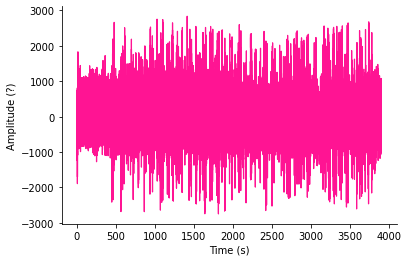

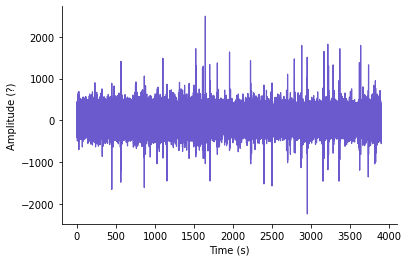

In [9]:
# Load up a file of interest
recording_of_interest = "fitted_data_mjc57-1212-0110.mat"
file_data = mat73.loadmat('/'.join([os.getcwd(), 'data', 'raw', recording_of_interest]))

theta = file_data['lfp']
theta_time_axis = file_data['time_eeg']
trial_times = file_data['pl']
print(file_data.keys())

# Visualize theta LFP
start = 0
stop = -1

plt.close()
fig, ax = plt.subplots()
fig.patch.set_alpha(0.0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.plot(theta_time_axis[start:stop], theta[start:stop], linewidth=1.2, color='deeppink')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (?)')

plt.show()

# Bandpass filter theta LFP

# Signal characteristics
theta_fs = theta_time_axis.size/theta_time_axis[-1] # Sampling frequency
theta_nyq = 0.5*theta_fs

# Filter characteristics
filter_order = 2
lowcut = 2 / theta_nyq 
highcut = 12 / theta_nyq

b, a = butter(filter_order, [lowcut, highcut], btype='band') # The IIR
theta_filtered = lfilter(b, a, theta) # Applying the filter

# Revisualize theta LFP
plt.close()
fig, ax = plt.subplots()
fig.patch.set_alpha(0.0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.plot(theta_time_axis[start:stop], theta_filtered[start:stop], linewidth=1.2, color='slateblue')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (?)')

plt.show()

In [10]:
#  
